<a href="https://colab.research.google.com/github/pkundu25/AI-Research/blob/master/Telecom_Attack_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Problem

To identify whether a telecom network is under attack or not based on the network logs.

## Importing the packages

In [ ]:
# Uploading files to colab

from google.colab import files
files.upload()

MessageError: ignored

In [ ]:
import pandas as pd                                                       # Pandas package for reading csv files
import numpy as np                                                        # Numpy package for computing
import matplotlib.pyplot as plt                                           # Visualization package

%matplotlib inline

In [ ]:
import seaborn as sns                                                     # Visualization package

import dask.dataframe as dd                                               # Dask to read dataframe



In [ ]:
# Installing necessary packages

!pip -q install shap
!pip -q install lime
!pip -q install eli5

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 112kB 2.9MB/s 


### Reading the data with Pandas

In [ ]:
%time                                                           # Check the time to run a particular cell

train = pd.read_csv('new_train.csv')                             # Reading data using simple Pandas

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 16.2 µs


In [ ]:
train = train.sample(frac = 0.05, random_state=10)    # Sampling the data with 1/10th of the records

### Reading the data with Dask

In [ ]:
%time                                                           # Check the time to read a particular cell

dask_train = dd.read_csv('new_train.csv')                        # Reading data using dask

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


For now we will continue to work with our pandas dataframe.

In [ ]:
print(train.shape)  # Checking the number of rows and columns in the dataframe
train.shape

(4100, 43)


(4100, 43)

In [ ]:
pd.set_option('display.max_columns', 50)                          # For displaying all the columns

train.head()

,Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,Num_failed_logins,Logged_in,Num_compromised,Root_shell,Su_attempted,Num_root,Num_file_creations,Num_shells,Num_access_files,Num_outbound_cmds,Is_hot_login,Is_guest_login,Count,Srv_count,Serror_rate,Srv_serror_rate,Rerror_rate,Srv_rerror_rate,Same_srv_rate,Diff_srv_rate,Srv_diff_host_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack,last_flag
44610,484,tcp,telnet,SF,396,11791,0,0,0,0,0,1,3,0,0,0,0,0,1,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,5,0.02,0.84,0.00,0.00,0.83,0.0,0.0,0.0,0.0,21
39250,0,tcp,http,SF,208,2684,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,21
25767,0,tcp,http,SF,309,1937,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26,255,1.00,0.00,0.04,0.04,0.00,0.0,0.0,0.0,0.0,21
63605,0,udp,domain_u,SF,45,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,144,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,18
50264,0,tcp,http,SF,213,564,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14,255,1.00,0.00,0.07,0.04,0.00,0.0,0.0,0.0,0.0,21


In [ ]:
# Lets have a look at the attack column which is the target column to be predicted

train.iloc[:,-2].value_counts()

0.0    3340
1.0     760
Name: attack, dtype: int64

This is an imbalanced class classification

## Exploratory Data Analysis

In [ ]:
# Using Pandas profiling package to perform EDA

import pandas_profiling

reports1=pandas_profiling.ProfileReport(train)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [ ]:
reports1.to_file('train_merge_EDA.html')                                   # Creating HTML file of pandas-profiling report

In this report we are able to see that there is strong correlation between a lot of columns.  <br>
If this were a regression problem these columns are bad and needed to be dropped. But this is a classification columns.

In [ ]:
# Checking the data types and missing values

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4100 entries, 44610 to 27921
Data columns (total 43 columns):
Duration                       4100 non-null int64
Protocol_type                  4100 non-null object
Service                        4100 non-null object
Flag                           4100 non-null object
Src_bytes                      4100 non-null int64
Dst_bytes                      4100 non-null int64
Land                           4100 non-null int64
Wrong_fragment                 4100 non-null int64
Urgent                         4100 non-null int64
Hot                            4100 non-null int64
Num_failed_logins              4100 non-null int64
Logged_in                      4100 non-null int64
Num_compromised                4100 non-null int64
Root_shell                     4100 non-null int64
Su_attempted                   4100 non-null int64
Num_root                       4100 non-null int64
Num_file_creations             4100 non-null int64
Num_shells        

**There are no null values.**

In [ ]:
# Lets separate the categorical columns

cat_cols = ['Protocol_type','Service','Flag']

**Descriptive Analysis of the columns**

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,4100.0,186.396341,1645.435417,0.0,0.00,0.00,0.00,40272.0
Src_bytes,4100.0,10307.370488,164790.173911,0.0,36.00,213.50,311.00,5133876.0
Dst_bytes,4100.0,4301.112927,83880.378201,0.0,0.00,307.50,1481.25,5151049.0
Land,4100.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0
Wrong_fragment,4100.0,0.005854,0.126757,0.0,0.00,0.00,0.00,3.0
Urgent,4100.0,0.000244,0.015617,0.0,0.00,0.00,0.00,1.0
Hot,4100.0,0.215610,2.194684,0.0,0.00,0.00,0.00,30.0
Num_failed_logins,4100.0,0.000732,0.034918,0.0,0.00,0.00,0.00,2.0
Logged_in,4100.0,0.584878,0.492803,0.0,0.00,1.00,1.00,1.0
Num_compromised,4100.0,0.198049,7.958099,0.0,0.00,0.00,0.00,373.0


There are 39 numeric columns. <br>
A lot of them are binary and a few have numeric values.  <br>
Lets have a look at their correlation plot. 

In [ ]:
# Lets plot the correlation matrix 

corr_matrix = train.corr()
corr_matrix

,Duration,Src_bytes,Dst_bytes,Land,Wrong_fragment,Urgent,Hot,Num_failed_logins,Logged_in,Num_compromised,Root_shell,Su_attempted,Num_root,Num_file_creations,Num_shells,Num_access_files,Num_outbound_cmds,Is_hot_login,Is_guest_login,Count,Srv_count,Serror_rate,Srv_serror_rate,Rerror_rate,Srv_rerror_rate,Same_srv_rate,Diff_srv_rate,Srv_diff_host_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_srv_rate,Dst_host_diff_srv_rate,Dst_host_same_src_port_rate,Dst_host_srv_diff_host_rate,Dst_host_serror_rate,Dst_host_srv_serror_rate,Dst_host_rerror_rate,Dst_host_srv_rerror_rate,attack,last_flag
Duration,1.000000,0.039807,0.009030,NaN,-0.005233,-0.000963,0.000819,0.011171,-0.089708,0.193528,0.094994,0.181685,0.190890,0.143256,-0.002503,0.158931,NaN,NaN,-0.003315,-0.052597,-0.045188,-0.033224,-0.044595,0.095474,0.096548,0.004624,0.046074,-0.048113,0.072836,-0.164393,-0.178023,0.344968,0.260488,-0.026814,-0.030264,-0.035133,0.089876,0.101470,0.028828,-0.092663
Src_bytes,0.039807,1.000000,-0.002941,NaN,-0.002830,-0.000964,0.029857,-0.001288,0.043038,-0.001345,-0.002441,-0.001524,-0.001508,-0.001658,-0.000774,-0.002532,NaN,NaN,-0.006154,-0.031847,-0.024135,-0.021445,-0.019579,-0.017618,-0.017265,0.025855,-0.002285,-0.014416,-0.033028,-0.058842,-0.026106,-0.002610,0.081409,-0.001812,-0.023939,-0.022929,-0.018561,-0.018160,0.011451,-0.064414
Dst_bytes,0.009030,-0.002941,1.000000,NaN,-0.002369,-0.000730,-0.000211,0.016120,0.012363,0.028054,0.053713,0.036671,0.027473,0.029773,-0.001133,0.025939,NaN,NaN,-0.002237,-0.024049,-0.017258,-0.013300,-0.016819,-0.012061,-0.011837,0.021297,-0.012753,-0.012505,-0.035604,-0.008589,0.021645,-0.014468,0.037503,-0.006163,-0.017668,-0.017879,-0.014178,-0.012114,0.014890,-0.082033
Land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wrong_fragment,-0.005233,-0.002830,-0.002369,NaN,1.000000,-0.000721,-0.004538,-0.000968,-0.054822,-0.001150,-0.001910,-0.001203,-0.001206,-0.001718,-0.001020,-0.002143,NaN,NaN,-0.004974,0.000887,-0.002007,0.011626,-0.018182,-0.013198,-0.013088,-0.007671,-0.007984,-0.011340,0.031723,-0.042932,-0.047348,0.109359,0.023965,-0.011238,-0.011484,-0.017527,0.053672,-0.013534,0.096823,-0.099347
Urgent,-0.000963,-0.000964,-0.000730,NaN,-0.000721,1.000000,-0.001535,-0.000327,0.013159,-0.000389,-0.000646,-0.000407,-0.000408,-0.000581,-0.000345,-0.000725,NaN,NaN,-0.001682,-0.008181,-0.006352,-0.006222,-0.006149,-0.004463,-0.004426,0.007341,-0.004177,-0.006670,-0.024273,-0.022159,0.011811,-0.005619,0.049097,0.134579,-0.006205,-0.005927,-0.004752,-0.004577,-0.007451,-0.008620
Hot,0.000819,0.029857,-0.000211,NaN,-0.004538,-0.001535,1.000000,-0.002059,0.082550,-0.002012,0.014782,-0.002558,-0.002565,-0.001162,-0.002171,-0.002333,NaN,NaN,0.856026,-0.051268,-0.039726,-0.036469,-0.036676,-0.027580,-0.026847,0.036699,0.014363,-0.037118,-0.012988,-0.111047,-0.093903,0.023887,-0.029599,-0.029415,-0.037760,-0.037070,-0.027127,-0.024417,-0.031423,-0.045102
Num_failed_logins,0.011171,-0.001288,0.016120,NaN,-0.000968,-0.000327,-0.002059,1.000000,-0.010699,0.002990,-0.000867,0.148609,0.001785,-0.000780,-0.000463,-0.000972,NaN,NaN,-0.002257,-0.010977,-0.008523,-0.008349,-0.008250,0.020930,0.021150,0.009850,-0.005605,-0.008949,-0.014333,-0.028360,-0.026696,0.000767,-0.009187,-0.007003,-0.008112,-0.006879,-0.003885,0.003957,-0.009997,-0.048804
Logged_in,-0.089708,0.043038,0.012363,NaN,-0.054822,0.013159,0.082550,-0.010699,1.000000,0.020969,0.034840,0.021936,0.021993,0.031342,0.018612,0.039083,NaN,NaN,0.090723,-0.529551,-0.311368,-0.409688,-0.418393,-0.328446,-0.321275,0.515124,-0.223100,0.116910,-0.321514,0.493022,0.477894,-0.263268,-0.221525,-0.066367,-0.409115,-0.427121,-0.301108,-0.289084,-0.535640,0.344902
Num_compromised,0.193528,-0.001345,0.028054,NaN,-0.001150,-0.000389,-0.002012,0.002990,0.020969,1.000000,0.535028,0.941762,0.998478,0.011175,-0.000550,0.795122,NaN,NaN,-0.002680,-0.011092,-0.0101

**Num_outbound_cmds** is empty column. We need to drop it.

**Let's check for any correlation in the data**

In [ ]:
%matplotlib inline

### Random 15 columns and make correlations

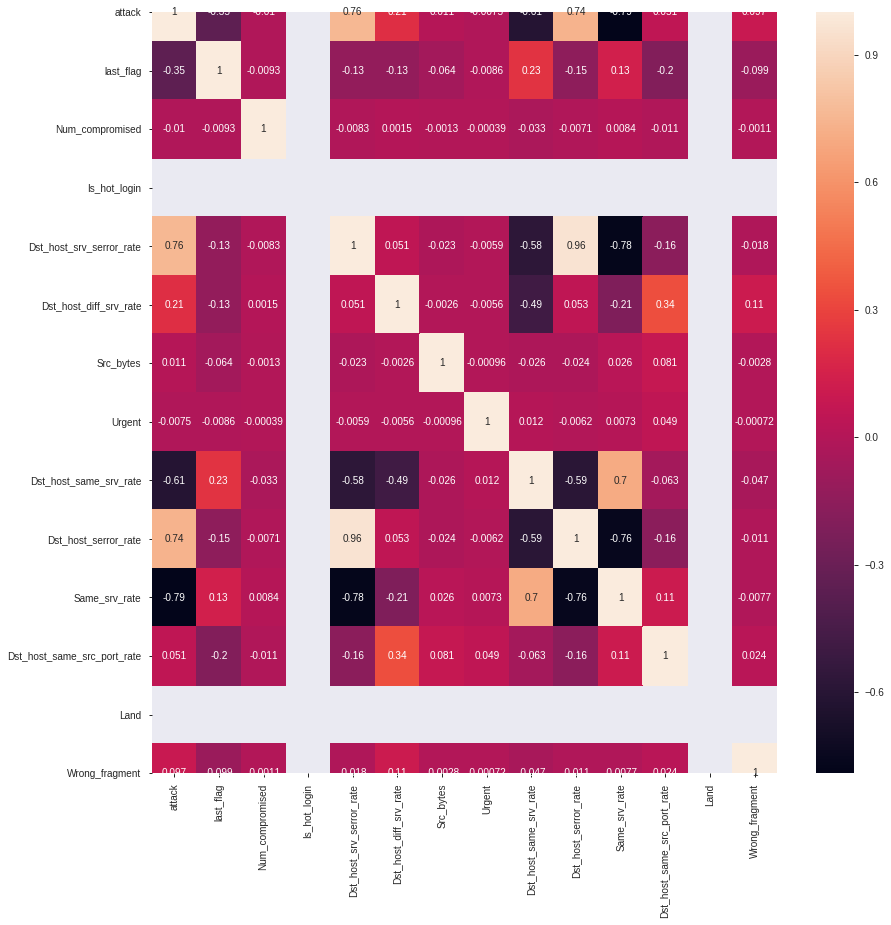

In [ ]:
# Lets take random 15 columns and plot the correlation matrix

small_df = train.sample(15, axis=1)
small_corr_matrix = small_df.corr()

plt.figure(figsize=(14,14))
sns.heatmap(small_corr_matrix, annot=True)

### Lets look at some strong correlations.

In [ ]:
col_names = train.columns                                         # Name of all the columns
col_names

Index(['Duration', 'Protocol_type', 'Service', 'Flag', 'Src_bytes',
       'Dst_bytes', 'Land', 'Wrong_fragment', 'Urgent', 'Hot',
       'Num_failed_logins', 'Logged_in', 'Num_compromised', 'Root_shell',
       'Su_attempted', 'Num_root', 'Num_file_creations', 'Num_shells',
       'Num_access_files', 'Num_outbound_cmds', 'Is_hot_login',
       'Is_guest_login', 'Count', 'Srv_count', 'Serror_rate',
       'Srv_serror_rate', 'Rerror_rate', 'Srv_rerror_rate', 'Same_srv_rate',
       'Diff_srv_rate', 'Srv_diff_host_rate', 'Dst_host_count',
       'Dst_host_srv_count', 'Dst_host_same_srv_rate',
       'Dst_host_diff_srv_rate', 'Dst_host_same_src_port_rate',
       'Dst_host_srv_diff_host_rate', 'Dst_host_serror_rate',
       'Dst_host_srv_serror_rate', 'Dst_host_rerror_rate',
       'Dst_host_srv_rerror_rate', 'attack', 'last_flag'],
      dtype='object')

In [ ]:
# In this block of code we are going to check all the variables with correlation above a certain threshold

corr_threshold = 0.8                                                 # This is a correlation threshold. We need to find variables with greater threshold

print("---------------CHECKING FOR CORRELATION------------")
for c in col_names:
    for r in col_names:
        if (r < c):
            if (c not in cat_cols) and (c is not 'attack') and (r not in cat_cols) and (r is not 'attack') :
                if abs(corr_matrix[r][c]) > corr_threshold:
                    print(c +" : "+ r+" : "+ str(corr_matrix[r][c]))

---------------CHECKING FOR CORRELATION------------
Su_attempted : Num_compromised : 0.9417623763834198
Su_attempted : Num_root : 0.9408185116907816
Num_root : Num_compromised : 0.998477943631432
Is_guest_login : Hot : 0.8560256379565698
Serror_rate : Dst_host_serror_rate : 0.9348705292759192
Serror_rate : Dst_host_srv_serror_rate : 0.9420496582745868
Srv_serror_rate : Serror_rate : 0.9790827532138668
Srv_serror_rate : Dst_host_serror_rate : 0.933003834390944
Srv_serror_rate : Dst_host_srv_serror_rate : 0.95892147239678
Rerror_rate : Dst_host_rerror_rate : 0.9078607633160453
Rerror_rate : Dst_host_srv_rerror_rate : 0.9189267532117935
Srv_rerror_rate : Rerror_rate : 0.9859930136689696
Srv_rerror_rate : Dst_host_rerror_rate : 0.8955936382796544
Srv_rerror_rate : Dst_host_srv_rerror_rate : 0.9203253344428932
Dst_host_srv_count : Dst_host_same_srv_rate : 0.9012295976890995
Dst_host_srv_serror_rate : Dst_host_serror_rate : 0.9644904019913957
Dst_host_srv_rerror_rate : Dst_host_rerror_rate :

We have found the same insights as profiling report.  <br>  <br>

We are going to plot some of these correlations.

**Lets separate our attack and normal connections and store in a separate dataframe.**

In [ ]:
y = train['attack']
y.unique()

array([0., 1.])

In [ ]:
y.value_counts()

0.0    3340
1.0     760
Name: attack, dtype: int64

## Plots

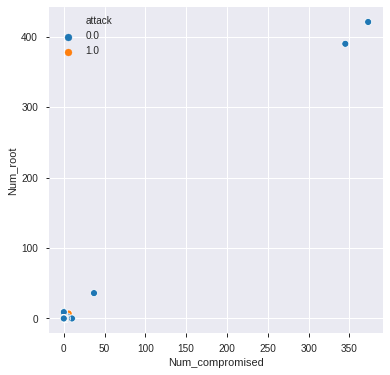

In [ ]:
# Scatter plot of Num_compromised and Num_root 

plt.figure(figsize=(6,6))
sns.scatterplot('Num_compromised','Num_root', data=train, hue=y)

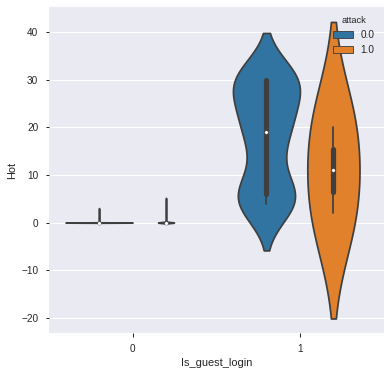

In [ ]:
# Violin plot of Is_guest_login and Hot

plt.figure(figsize=(6,6))
sns.violinplot('Is_guest_login', 'Hot', data=train, hue=y)

**Observation**: There are very few logins which are not guest.<br>
There are **guest logins** where **hot operations** are between 0-10 and 25-35 **are actually attack connections**.

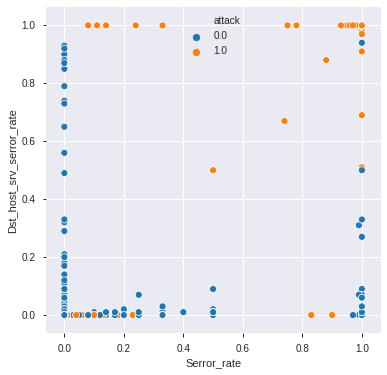

In [ ]:
# Scatter plot of Serror_rate and Dst_host_srv_serror_rate 

plt.figure(figsize=(6,6))
sns.scatterplot('Serror_rate', 'Dst_host_srv_serror_rate', data=train, hue=y)    

**Observation**: There are a lot of attacks happening.

In [ ]:
np.unique(y[train['Serror_rate'] > 0.5], return_counts=True)

(array([0., 1.]), array([ 35, 484]))

**Observation** : There are 8788 attacks when Serror_rate is greater than 0.5

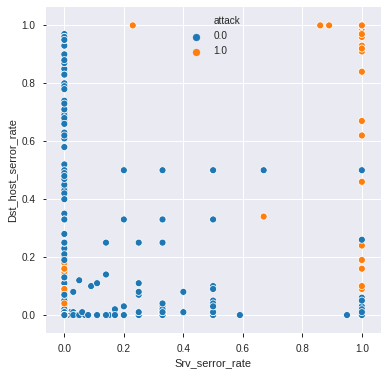

In [ ]:
# Scatter plot of Srv_serror_rate and Dst_host_serror_rate

plt.figure(figsize=(6,6))
sns.scatterplot('Srv_serror_rate', 'Dst_host_serror_rate', data=train, hue=y)    

**Observation**: **Srv_serror_rate** and **Dst_host_serror_rate** are clear indicators of attacks happening or not.  <br>
Basically if I draw a diagonal line, it will separate most of the attacks. <br>
Equation of the classification line will be **Srv_serror_rate** + **Dst_host_serror_rate** = 1

In [ ]:
np.unique(y[(train['Srv_serror_rate'] + train['Dst_host_serror_rate']) > 1], return_counts=True)

(array([0., 1.]), array([ 18, 488]))

**Observation** : 8786 attacks and 311 normal conditions when Srv_serror_rate + Dst_host_serror_rate greater than 1.

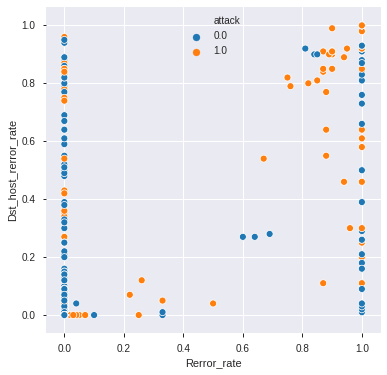

In [ ]:
# Scatter plot of Rerror_rate and Dst_host_rerror_rate  

plt.figure(figsize=(6,6))
sns.scatterplot('Rerror_rate', 'Dst_host_rerror_rate', data=train, hue=y)    

**Observation**: Lots of attacks when **rerror_rate** greater than 0.5

In [ ]:
y[train['Rerror_rate'] > 0.5].value_counts()
#np.unique(y[train['Rerror_rate'] > 0.5], return_counts=True)

0.0    166
1.0    140
Name: attack, dtype: int64

**Observation** : 3015 attacks and 2948 non attacks when rerror_rate greater than 0.5

Now we have done correlation plots and simple multivariate analysis to classify connections which are attack or normal.
Lets try to do this with machine learning algorithms.

**Feature Importance and Feature Selection using 'Greedy Search' method**


In [ ]:
# We will also drop the target column "attack" and "Num_outbound_cmds"
X = train.drop(['attack', 'Num_outbound_cmds'], axis = 1)
#X = X.reset_index()
X.shape


(4100, 41)

In [ ]:
X = X.drop(cat_cols, axis =1)
#X = X.reset_index()
X.shape

(4100, 38)

In [ ]:
y = train['attack']                                              # The target label
y.unique()

array([0., 1.])

In [ ]:
#To check if X contains null values
np.any(np.isnan(X))
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4100 entries, 44610 to 27921
Data columns (total 38 columns):
Duration                       4100 non-null int64
Src_bytes                      4100 non-null int64
Dst_bytes                      4100 non-null int64
Land                           4100 non-null int64
Wrong_fragment                 4100 non-null int64
Urgent                         4100 non-null int64
Hot                            4100 non-null int64
Num_failed_logins              4100 non-null int64
Logged_in                      4100 non-null int64
Num_compromised                4100 non-null int64
Root_shell                     4100 non-null int64
Su_attempted                   4100 non-null int64
Num_root                       4100 non-null int64
Num_file_creations             4100 non-null int64
Num_shells                     4100 non-null int64
Num_access_files               4100 non-null int64
Is_hot_login                   4100 non-null int64
Is_guest_login       

In [ ]:
#To check if X contains infinite values
np.all(np.isfinite(X))

True

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
Selector_f = SelectPercentile(f_regression, percentile=25)

Selector_f.fit(X,y)
for n,s in zip(train.columns,Selector_f.scores_):
 print ("F-score: %3.2f for feature %s" % (s,n))

F-score: 3.41 for feature Duration
F-score: 0.54 for feature Protocol_type
F-score: 0.91 for feature Service
F-score: nan for feature Flag
F-score: 38.78 for feature Src_bytes
F-score: 0.23 for feature Dst_bytes
F-score: 4.05 for feature Land
F-score: 0.41 for feature Wrong_fragment
F-score: 1648.82 for feature Urgent
F-score: 0.44 for feature Hot
F-score: 0.08 for feature Num_failed_logins
F-score: 0.63 for feature Logged_in
F-score: 0.59 for feature Num_compromised
F-score: 0.60 for feature Root_shell
F-score: 0.46 for feature Su_attempted
F-score: 1.03 for feature Num_root
F-score: nan for feature Num_file_creations
F-score: 6.43 for feature Num_shells
F-score: 2114.83 for feature Num_access_files
F-score: 3.64 for feature Num_outbound_cmds
F-score: 4567.59 for feature Is_hot_login
F-score: 4849.77 for feature Is_guest_login
F-score: 169.74 for feature Count
F-score: 162.33 for feature Srv_count
F-score: 6815.14 for feature Serror_rate
F-score: 121.75 for feature Srv_serror_rate
F-s

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import sklearn.linear_model as lr

#svr = SVR(kernel="linear")
#Create a Linear Regression estimator
regr = lr.LinearRegression()
selector = RFECV(estimator = regr, step =1, scoring = 'neg_mean_squared_error', cv=3)
selector.fit(X, y)
print("Optimal number of features: %d" % selector.n_features_)

Optimal number of features: 23


In [ ]:
selector.ranking_

array([12, 14, 13, 15,  1,  1,  4,  1,  1,  5,  1,  1,  6,  1,  1,  1, 16,
        3,  7, 11,  1,  1,  1,  1,  1,  1,  1, 10,  8,  2,  1,  1,  1,  1,
        1,  9,  1,  1])

In [ ]:
X.columns[selector.support_]


Index(['Wrong_fragment', 'Urgent', 'Num_failed_logins', 'Logged_in',
       'Root_shell', 'Su_attempted', 'Num_file_creations', 'Num_shells',
       'Num_access_files', 'Serror_rate', 'Srv_serror_rate', 'Rerror_rate',
       'Srv_rerror_rate', 'Same_srv_rate', 'Diff_srv_rate',
       'Srv_diff_host_rate', 'Dst_host_diff_srv_rate',
       'Dst_host_same_src_port_rate', 'Dst_host_srv_diff_host_rate',
       'Dst_host_serror_rate', 'Dst_host_srv_serror_rate',
       'Dst_host_srv_rerror_rate', 'last_flag'],
      dtype='object')

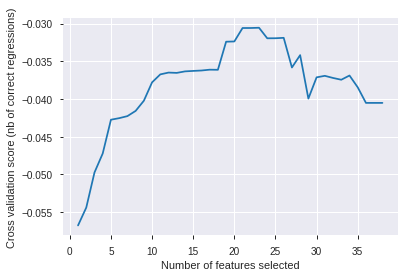

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct regressions)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# Handling Categorical Variables

In [ ]:
# Lets one hot encode all the categorical columns

encoded_cols = pd.get_dummies(train[cat_cols], drop_first=True)
encoded_cols.shape

(4100, 71)

In [ ]:
# We will concat the one hot encoded dataframe with train dataframe

train = pd.concat([train, encoded_cols], axis=1)
train.shape

(4100, 114)

# Creating Features and Labels

In [ ]:
# Lets drop the categorical column as we have already included one hot columns

X = train.drop(cat_cols, axis = 1)

# We will also drop the target column "attack" and "Num_outbound_cmds"
X = X.drop(['attack', 'Num_outbound_cmds'], axis = 1)

In [ ]:
X.shape                                                         # The number of rows and columns in the features

(4100, 109)

In [ ]:
y = train['attack']                                              # The target label
y.unique()

array([0., 1.])

In [ ]:
# Lets create our train and validation split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
# metrics

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, recall_score

In [ ]:
def model_train(model, name):
    model.fit(X_train, y_train)                                          # Fitting the model
    y_pred = model.predict(X_test)                                       # Making prediction from the trained model
    print(name + " Validation Data")
    cm = confusion_matrix(y_test, y_pred)                               
    print(name +" Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
    print(cm)
    print('-----------------------')
    cr = classification_report(y_test, y_pred)
    print(name +" Classification Report " +" Validation Data")           # Displaying the Classification Report
    print(cr)
    print('------------------------')
    print(name +" AUC Score " +" Validation Data")
    auc = roc_auc_score(y_test, y_pred)       
    print("AUC Score " + str(auc))                                       # Displaying the AUC score
    print(name +" Recall " +" Validation Data")
    rec = recall_score(y_test, y_pred)
    print("Recall "+ str(rec))                                           # Displaying the Recall score
    print('_________________________')
    print(name + " Bias")                                                 # Calculating bias
    bias = y_pred - y_test.mean()
    print("Bias "+ str(bias.mean()))
    
    print(name + " Variance")                                             # Calculate Variance
    var = np.var([y_test, y_pred], axis=0)
    print("Variance " + str(var.mean()) )
    return auc, rec, model



# Model Building

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101)

In [ ]:
lr_auc, lr_rec, lr_model = model_train(lr, "Logistic Regression")

Logistic Regression Validation Data
Logistic Regression Confusion Matrix  Validation Data
[[664   3]
 [  5 148]]
-----------------------
Logistic Regression Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       667
         1.0       0.98      0.97      0.97       153

    accuracy                           0.99       820
   macro avg       0.99      0.98      0.98       820
weighted avg       0.99      0.99      0.99       820

------------------------
Logistic Regression AUC Score  Validation Data
AUC Score 0.9814112551567354
Logistic Regression Recall  Validation Data
Recall 0.9673202614379085
_________________________
Logistic Regression Bias
Bias -0.0024390243902438725
Logistic Regression Variance
Variance 0.0024390243902439024


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model is not so great with a lot of FN.

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini',max_depth = 10, min_samples_leaf =3, random_state=101)

In [ ]:
dt_auc, dt_rec, dt_model = model_train(dt, "Decision Tree")

Decision Tree Validation Data
Decision Tree Confusion Matrix  Validation Data
[[665   2]
 [  6 147]]
-----------------------
Decision Tree Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       667
         1.0       0.99      0.96      0.97       153

    accuracy                           0.99       820
   macro avg       0.99      0.98      0.98       820
weighted avg       0.99      0.99      0.99       820

------------------------
Decision Tree AUC Score  Validation Data
AUC Score 0.9788929064879326
Decision Tree Recall  Validation Data
Recall 0.9607843137254902
_________________________
Decision Tree Bias
Bias -0.004878048780487773
Decision Tree Variance
Variance 0.0024390243902439024


**The metric of our choice should be Recall as we want to minimize FN, which means that an attack accured but the model did not detect it.**

## Random Forest Algorithm

In [ ]:
# Random Forest Algorithm

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 20, criterion='gini', max_depth = 10, min_samples_split=3, random_state=101)

In [ ]:
rf_auc, rf_rec, rf_model = model_train(rf_clf, "Random Forest Classifier")

Random Forest Classifier Validation Data
Random Forest Classifier Confusion Matrix  Validation Data
[[665   2]
 [  4 149]]
-----------------------
Random Forest Classifier Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       667
         1.0       0.99      0.97      0.98       153

    accuracy                           0.99       820
   macro avg       0.99      0.99      0.99       820
weighted avg       0.99      0.99      0.99       820

------------------------
Random Forest Classifier AUC Score  Validation Data
AUC Score 0.985428854200351
Random Forest Classifier Recall  Validation Data
Recall 0.9738562091503268
_________________________
Random Forest Classifier Bias
Bias -0.002439024390243871
Random Forest Classifier Variance
Variance 0.001829268292682927


## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

random_grid = {'n_estimators': range(5,20,2),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [10,20,30,40],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,2,4]}

rf = RandomForestClassifier()

rf_gs = GridSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

rf_gs.fit(X_train, y_train)
y_pred = rf_gs.predict(X_test)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1358 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:   58.9s finished


In [ ]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:

print("Grid Search Validation Data")
cm = confusion_matrix(y_test, y_pred)                               
print("Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
print(cm)
print('-----------------------')
cr = classification_report(y_test, y_pred)
print("Grid Search Classification Report " +" Validation Data")           # Displaying the Classification Report
print(cr)
print('------------------------')
print("Grid Search AUC Score " +" Validation Data")
auc = roc_auc_score(y_test, y_pred)       
print("AUC Score " + str(auc))                                       # Displaying the AUC score
print("Grid Search Recall " +" Validation Data")
rec = recall_score(y_test, y_pred)
print("Recall "+ str(rec))                                           # Displaying the Recall score
print('_________________________')
print("Grid Search Bias")                                                 # Calculating bias
bias = y_pred - y_test.mean()
print("Bias "+ str(bias.mean()))
    
print("Grid Search Variance")                                             # Calculate Variance
var = np.var([y_test, y_pred], axis=0)
print("Variance " + str(var.mean()) )

Grid Search Validation Data
Grid Search Confusion Matrix  Validation Data
[[665   2]
 [  2 151]]
-----------------------
Grid Search Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       667
         1.0       0.99      0.99      0.99       153

    accuracy                           1.00       820
   macro avg       0.99      0.99      0.99       820
weighted avg       1.00      1.00      1.00       820

------------------------
Grid Search AUC Score  Validation Data
AUC Score 0.9919648019127691
Grid Search Recall  Validation Data
Recall 0.9869281045751634
_________________________
Grid Search Bias
Bias 3.1411188013784914e-17
Grid Search Variance
Variance 0.0012195121951219512


## Randomized Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    2.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


In [ ]:

print("Randomized Grid Search Validation Data")
cm = confusion_matrix(y_test, y_pred)                               
print("Randomized Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
print(cm)
print('-----------------------')
cr = classification_report(y_test, y_pred)
print("Randomized Grid Search Classification Report " +" Validation Data")           # Displaying the Classification Report
print(cr)
print('------------------------')
print("Randomized Grid Search AUC Score " +" Validation Data")
auc = roc_auc_score(y_test, y_pred)       
print("AUC Score " + str(auc))                                       # Displaying the AUC score
print("Randomized Grid Search Recall " +" Validation Data")
rec = recall_score(y_test, y_pred)
print("Recall "+ str(rec))                                           # Displaying the Recall score
print('_________________________')
print("Randomized Grid Search Bias")                                                 # Calculating bias
bias = y_pred - y_test.mean()
print("Bias "+ str(bias.mean()))
    
print("Randomized Grid Search Variance")                                             # Calculate Variance
var = np.var([y_test, y_pred], axis=0)
print("Variance " + str(var.mean()) )

Randomized Grid Search Validation Data
Randomized Grid Search Confusion Matrix  Validation Data
[[666   1]
 [  4 149]]
-----------------------
Randomized Grid Search Classification Report  Validation Data
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       667
         1.0       0.99      0.97      0.98       153

    accuracy                           0.99       820
   macro avg       0.99      0.99      0.99       820
weighted avg       0.99      0.99      0.99       820

------------------------
Randomized Grid Search AUC Score  Validation Data
AUC Score 0.9861784793877572
Randomized Grid Search Recall  Validation Data
Recall 0.9738562091503268
_________________________
Randomized Grid Search Bias
Bias -0.0036585365853658218
Randomized Grid Search Variance
Variance 0.001524390243902439


In [ ]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Model Explainations

### Permutation Importance

We will run the permutation importance using Decision Tree Classifier

In [ ]:
import eli5

from eli5.sklearn import PermutationImportance

perm = PermutationImportance(dt_model, random_state=101).fit(X_test, y_test)      # Evaluate the permutation importance 
eli5.show_weights(perm, feature_names = X_test.columns.values)                    # Display the weights of each features

Using TensorFlow backend.


Weight,Feature
0.1395 ± 0.0109,Src_bytes
0.1088 ± 0.0125,Dst_bytes
0.0322 ± 0.0057,Service_http
0.0215 ± 0.0065,last_flag
0.0156 ± 0.0036,Same_srv_rate
0.0132 ± 0.0024,Service_ecr_i
0.0041 ± 0.0040,Srv_count
0.0020 ± 0.0012,Service_smtp
0.0017 ± 0.0012,Flag_RSTO
0.0017 ± 0.0012,Dst_host_same_srv_rate


Lets check the same with Random Forest classifier

In [ ]:
perm = PermutationImportance(rf_model, random_state=101).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.values)

Weight,Feature
0.0110 ± 0.0034,Src_bytes
0.0037 ± 0.0015,Count
0.0034 ± 0.0010,Service_ecr_i
0.0032 ± 0.0020,last_flag
0.0027 ± 0.0010,Dst_host_srv_rerror_rate
0.0022 ± 0.0036,Logged_in
0.0015 ± 0.0018,Service_http
0.0012 ± 0.0000,Hot
0.0012 ± 0.0015,Dst_host_rerror_rate
0.0012 ± 0.0034,Dst_bytes


**Conclusion**: The columns in the green are the most important features.

### Shap

Lets see how the columns impact a single record of data

In [ ]:
row_to_show = 7                                                                # The row for which we want to check the SHAP explanations
data_to_predict = X_test.iloc[row_to_show]
#data_to_predict

In [ ]:
data_to_preddict_array = data_to_predict.values.reshape(1,-1)

dt_model.predict_proba(data_to_preddict_array)                                 # Prediction probability on the row of the data

array([[1., 0.]])

In [ ]:
dt_model.predict(data_to_preddict_array)                                       # Predicted output

array([0.])

In [ ]:
y_test.iloc[row_to_show]

0.0

In [ ]:
import shap

# Object that can calculate Shap values
explainer = shap.TreeExplainer(dt_model)                                       # SHAP Tree Explainer

# Calculate the shap values
shap_values = explainer.shap_values(data_to_predict)                           # SHAP explanations

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_to_predict)

### LIME

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                         feature_names=X_train.columns.values.tolist(),
                                                         mode='classification',class_names='Attack')


In [ ]:
lime_expln1=explainer.explain_instance(X_test.iloc[1],dt_model.predict_proba,num_features=X_test.shape[1], top_labels = 1)
lime_expln1.show_in_notebook(show_table=True, show_all=False)